In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import Text, messagebox
from tkinter.ttk import Button, Label

In [3]:
df = pd.read_csv('Call Of Duty.csv')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3882 entries, 0 to 3881
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   reviews  3882 non-null   object
 1   ratings  3882 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 60.8+ KB


In [20]:
df.duplicated().sum()

np.int64(3)

In [4]:
df = df.drop_duplicates(keep='first')

In [23]:
df['ratings'].unique()

array([4, 1, 3, 2, 5])

### asdjak

In [8]:
X = df.drop('ratings', axis=1)
y = df['ratings']

In [9]:
def preprocess(text):
    text = text.lower()
    cleaned = ''
    for char in text:
        if (char >= 'a' and char <= 'z') or (char >= '0' and char <= '9') or char == ' ':
            cleaned += char
    words = []
    current_word = ''
    for char in cleaned:
        if char == ' ':
            if current_word:
                words.append(current_word)
            current_word = ''
        else:
            current_word += char
    if current_word:
        words.append(current_word)
    return words

In [10]:
df['processed_reviews'] = df['reviews'].apply(preprocess)
print(df['processed_reviews'].head())

0    [ive, been, playing, for, years, now, and, its...
1    [an, annoying, experience, all, round, ever, s...
2    [i, love, the, game, though, its, close, to, r...
5    [cod, happens, to, be, my, best, mobile, game,...
6    [codm, is, awesome, and, i, can, guarantee, is...
Name: processed_reviews, dtype: object


In [12]:
np.random.seed(42)

indicies = np.random.permutation(len(X))
train_size = int(0.75 * len(X))

# Use .iloc to select rows by integer positions when X/y are pandas objects
X_train = X.iloc[indicies[:train_size]]
y_train = y.iloc[indicies[:train_size]]
X_test = X.iloc[indicies[train_size:]]
y_test = y.iloc[indicies[train_size:]]

In [13]:
vocab = set()
for review in X_train:
    for word in review:
        vocab.add(word)
vocab = list(vocab)
V = len(vocab)
print("Vocabulary size:", V)

Vocabulary size: 11


In [14]:
classes = np.unique(y_train)
priors = {}
for c in classes:
    priors[c] = np.sum(y_train == c) / len(y_train)
print("p",priors)

p {np.int64(1): np.float64(0.2423513234788587), np.int64(2): np.float64(0.1151598487452733), np.int64(3): np.float64(0.1519422481952561), np.int64(4): np.float64(0.18459951873496047), np.int64(5): np.float64(0.30594706084565143)}


In [16]:
word_counts = {c: {} for c in classes}
total_words = {c: 0 for c in classes}
for i in range(len(X_train)):
    # use positional indexing to avoid KeyError from label-based indexing in pandas Series
    c = y_train.iloc[i]
    # access the tokenized/processed review column
    tokens = X_train.iloc[i]['processed_reviews']
    if not tokens:
        continue
    for word in tokens:
        word_counts[c][word] = word_counts[c].get(word, 0) + 1
        total_words[c] += 1
print("Total words per class:", total_words)

Total words per class: {np.int64(1): 39592, np.int64(2): 18716, np.int64(3): 25937, np.int64(4): 29968, np.int64(5): 47678}


In [17]:
def predict(words):
    log_posteriors = {}
    for c in classes:
        log_prob = np.log(priors[c])
        for word in words:
            count = word_counts[c].get(word, 0)
            likelihood = (count + 1) / (total_words[c] + V)
            log_prob += np.log(likelihood)
        log_posteriors[c] = log_prob
    return max(log_posteriors, key=log_posteriors.get)

In [19]:
y_pred = []
# iterate over the tokenized reviews column (each item is a list of tokens)
for tokens in X_test['processed_reviews']:
    # if tokens somehow are raw strings, turn them into tokens using preprocess
    if isinstance(tokens, str):
        words = preprocess(tokens)
    else:
        words = tokens
    y_pred.append(predict(words))

y_pred = np.array(y_pred)
accuracy = np.mean(y_pred == y_test.to_numpy())
print("Accuracy:", accuracy * 100, "%")

Accuracy: 34.74226804123711 %


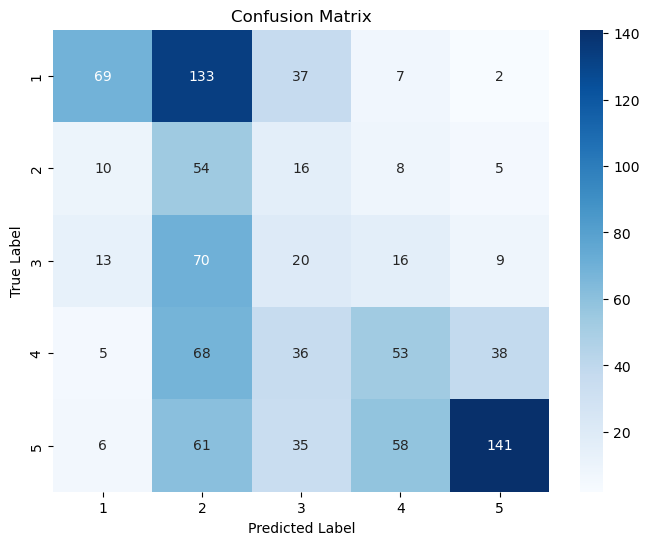

In [20]:
conf_matrix = np.zeros((len(classes), len(classes)), dtype=int)
class_to_idx = {c: i for i, c in enumerate(classes)}
for true, pred in zip(y_test, y_pred):
    conf_matrix[class_to_idx[true], class_to_idx[pred]] += 1

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [27]:
def gui_predict():
    input = entry.get("1.0", "end-1c")
    if not input.strip():
        messagebox.showwarning("Input Error", "Please enter a review.")
        return
    words = preprocess(input)
    prediction = predict(words)
    messagebox.showinfo("Prediction", f"The predicted rating is: {prediction}")

root = tk.Tk()
root.title("Call of Duty Review Rating Predictor")

label = Label(root, text="Enter your Call of Duty review:")
label.pack()

entry = Text(root, height=10, width=50)
entry.pack()

button = Button(root, text="Predict Rating", command=gui_predict)
button.pack()

root.mainloop()